In [1]:
from skimage import io
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
from skimage.color import (separate_stains, combine_stains,
                            hdx_from_rgb, rgb_from_hdx,rgb2hed, hed2rgb) 

from skimage import img_as_ubyte
from skimage.exposure import rescale_intensity
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets

# Funciones

In [2]:
#Leer el conjunto de imagenes
def LeerImagenes(imagenes):
    imgs=[]
    for x in range(0,len(imagenes)):
        imgs.append(io.imread(imagenes[x]))
    MImagenes=np.array(imgs)
    
    return MImagenes

In [3]:
#Crea matriz con las etiquetas de las imagenes
def Etiquetas(imagenes):
    etiquetas=[]
    for x in range(0,len(imagenes)):
        Clasificacion =imagenes[x].split('-') 
        for i in range(0,len(Clasificacion)) :
            Valores=(Clasificacion[2])
            Numero=Valores.split('_')
        etiquetas.append(int(Numero[1]))
    return etiquetas

In [4]:
#Aplico filtro al conjunto de imagenes ingresados cono paramentro
def AplicarFiltro(MImagenes):
    imgs_con_filtro=[]
    for x in range(0,len(MImagenes)):
        ihc_hdx = rgb2hed(MImagenes[x])
        null = np.zeros_like(ihc_hdx[:, :, 0])
        ihc_h = hed2rgb(np.stack((ihc_hdx[:, :, 0], null, null), axis=-1))
        ihc_d = hed2rgb(np.stack((null, ihc_hdx[:, :, 1], null), axis=-1))
        ihc_x = hed2rgb(np.stack((null, null, ihc_hdx[:, :, 2]), axis=-1))

        h = rescale_intensity(ihc_hdx[:, :, 0], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 0], 99)))
        d = rescale_intensity(ihc_hdx[:, :, 2], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 2], 99)))
    
        zdh = np.dstack((null, d, h))
        imgs_con_filtro.append(zdh)
    Imagenes_con_fitro=np.array(imgs_con_filtro)
    return Imagenes_con_fitro

In [5]:
# Constantes
data_source = "../data/"
models_dir = '../saved_models/'
train_imgs = glob(f"{data_source}training/*.png")
test_imgs = glob(f"{data_source}test/*.png")

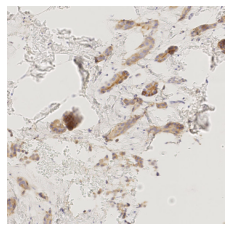

In [6]:
#leer imagenes
Imagenes=LeerImagenes(test_imgs)
#Muestro ejemplo de la imagen sin filtro
plt.figure()
plt.imshow(Imagenes[20])
plt.axis("off")
plt.show()

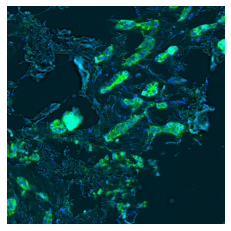

In [7]:
Imagenesconfiltro=AplicarFiltro(Imagenes)
#Muestro ejemplo de imagen con filtro
plt.figure()
plt.imshow(Imagenesconfiltro[20])
plt.axis("off")
plt.show()

In [6]:
X_train=AplicarFiltro(LeerImagenes(train_imgs))
y_train=Etiquetas(train_imgs)
X_test=AplicarFiltro(LeerImagenes(test_imgs))
y_test=Etiquetas(test_imgs)

In [7]:
n_classes = 4
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print(Y_train[1])

[0. 0. 0. 1.]


In [24]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [9]:
print(len(X_train))
print(len(X_test))

1600
200


In [10]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(300,300,3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(4, activation='softmax'))

In [11]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# training the model for 10 epochs
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
13/13 [==============================] - 51s 4s/step - loss: 97.3176 - accuracy: 0.4044 - val_loss: 30.9295 - val_accuracy: 0.4900
Epoch 2/10
13/13 [==============================] - 43s 3s/step - loss: 19.1071 - accuracy: 0.5556 - val_loss: 8.2841 - val_accuracy: 0.5750
Epoch 3/10
13/13 [==============================] - 41s 3s/step - loss: 5.5724 - accuracy: 0.6906 - val_loss: 3.5947 - val_accuracy: 0.5350
Epoch 4/10
13/13 [==============================] - 41s 3s/step - loss: 1.7968 - accuracy: 0.7575 - val_loss: 1.9641 - val_accuracy: 0.5500
Epoch 5/10
13/13 [==============================] - 41s 3s/step - loss: 0.4834 - accuracy: 0.8856 - val_loss: 1.4349 - val_accuracy: 0.5600
Epoch 6/10
13/13 [==============================] - 41s 3s/step - loss: 0.1791 - accuracy: 0.9506 - val_loss: 0.9442 - val_accuracy: 0.6650
Epoch 7/10
13/13 [==============================] - 42s 3s/step - loss: 0.0754 - accuracy: 0.9887 - val_loss: 1.0066 - val_accuracy: 0.6450
Epoch 8/10
13/13 

In [12]:
X_pred=model.predict(X_test)

In [13]:
print(X_pred)

[[9.73581254e-01 2.64187045e-02 3.38655808e-18 1.16975178e-18]
 [3.62090856e-01 6.37909174e-01 4.10349116e-10 2.64511607e-10]
 [9.89440858e-01 1.05592245e-02 1.03024945e-12 3.67382687e-12]
 [9.53594983e-01 4.64049876e-02 1.42742534e-12 4.47533894e-12]
 [6.36034667e-01 3.63965273e-01 2.41396552e-18 4.66448285e-19]
 [9.95119810e-01 4.88020200e-03 3.08430008e-17 7.35661191e-16]
 [7.58621812e-01 2.41378218e-01 1.52028987e-10 5.06035491e-10]
 [9.97010231e-01 2.98972987e-03 5.82030601e-15 9.51021380e-13]
 [9.98731554e-01 1.26849313e-03 2.45234172e-13 5.51302996e-11]
 [9.87045527e-01 1.29544688e-02 3.37018419e-26 9.08382145e-26]
 [9.80908275e-01 1.90916657e-02 2.15085463e-10 6.07208117e-10]
 [9.88204598e-01 1.17953885e-02 1.09562403e-11 1.25516500e-10]
 [9.97942150e-01 2.05778168e-03 3.01742385e-17 4.75231011e-17]
 [9.27904069e-01 7.20959380e-02 4.39050109e-14 8.13684461e-13]
 [4.36743766e-01 5.00720024e-01 6.12283014e-02 1.30793010e-03]
 [3.54717635e-02 9.11372602e-01 3.98320295e-02 1.332351

In [14]:
Tabla=np.array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
class_names=['0' '1' '2' '3']

In [15]:
classifier = svm.SVC(kernel='linear').fit(Tabla, Tabla.argmax(axis=1))
predicted_labels = classifier.predict(X_pred)

In [16]:
cnf_matrix = confusion_matrix(Y_test.argmax(axis=1), predicted_labels)
print(cnf_matrix)

[[34 16  0  0]
 [10 23 15  2]
 [ 0  1 33 16]
 [ 0  0  2 48]]


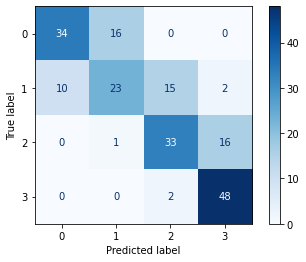

In [17]:
disp = plot_confusion_matrix(classifier, X_pred, Y_test.argmax(axis=1),
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [18]:
print(cnf_matrix.sum(axis=0))
print(np.diag(cnf_matrix) )
print(cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) )

[44 40 50 66]
[34 23 33 48]
[10 17 17 18]


In [21]:
print(Y_test.argmax(axis=1))
print(X_pred.argmax(axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3
 3 3 3 3 3 3 2 3 3 3 3 3 2 1 1 1 1 1 2 2 2 2 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 0 1 1 1 1 1 0 0 1 1 1 1 2 2 1 1 2 1 0 1 2 1 1 2 2 3 3 3 3 2 3 2 2 3 3 3
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2 3 2 3 2 2 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 2 0 0 1 0 1 2 0 1 0 1 2 2 0 2 3
 1 2 3 1 3 3 3 3 3 3 3 3 3 3 3]
